# Regression for causal inference: election forecasting

This notebook follows the example from section 14.3 of *Bayesian Data Analysis.* The data files for this analysis are available at http://www.stat.columbia.edu/~gelman/book/data/incumbency/.

In [1]:
# Imports
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, matplotlib.pyplot as plt
from scipy import stats
from modelutils import *

## The model

The basic model is a multiple linear regression. We define the following variables:
* $V_i^{(t)}$: the vote share of the incumbent party in district $i$, year $t$
* $P_i^{(t)}$: the identity of the incumbent party in district $i$, year $t$
* $I_i^{(t)}$: an indicator variable for whether the incumbent ran in district $i$, year $t$.

Then the model is formulated as follows. (Note: all variables have an implicit superscript $t$ *except* $V_i^{(t-2)}$).
$$ 
\begin{align*}
V_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_I I_i + \beta_P P_i + \beta_V V_i^{(t-2)} \\
\alpha &\sim \mathrm{Normal(0, 0.3)} \\
\beta_I &\sim \mathrm{Normal(0, 0.3)} \\
\beta_P &\sim \mathrm{Normal(0, 0.3)} \\
\beta_V &\sim \mathrm{Normal(0, 0.3)} \\
\sigma &\sim \mathrm{HalfCauchy(1)}
\end{align*}
$$

## Setting up the model in PyMC3

We define two helper functions to do the computation. The first, given a year, loads the data files for that year and the previous year, joins them into a single data frame, and drops rows corresponding to elections where candidates ran unopposed (using a vote total of 0 as a proxy for this). Then, we calculate three variables that go into our model:
* the identity of the incumbent party (1 = Democratic, -1 = Republican). Note that this isn't the same as the incumbency code. Incumbency code 0 means that the incumbent didn't run; however, we're still interested in which *party* held the seat last.
* the vote share of the incumbent party this year (the outcome variable)
* the vote share of the incumbent party the previous year (a control variable used as a proxy for the "safety" of the seat)

In [2]:
def create_merged_data(year):
    '''
    Creates a data frame with the necessary variables to estimate incumbency advantage in a given year.
    Parameters:
        year: the desired year (int)
    Returns: DataFrame
    '''
    # Load this year and the previous election's data
    df_past = pd.read_fwf(str(year - 2) + '.asc', names = ['state', 'district', 'incumbent', 'dem_votes', 'rep_votes'])
    df_pres = pd.read_fwf(str(year) + '.asc', names = ['state', 'district', 'incumbent', 'dem_votes', 'rep_votes'])
    
    # Join the data frames
    df = df_past.join(df_pres, lsuffix = '_past').drop(['state_past', 'district_past'], axis = 'columns')
    # Drop rows where candidates were unopposed
    df = df[(df.dem_votes > 0) & (df.rep_votes > 0) & (df.dem_votes_past > 0) & (df.rep_votes_past > 0)]
    
    # Compute auxiliary quantities
    df['incumbent_party'] = 2*(df.dem_votes_past > df.rep_votes_past).astype(np.int64) - 1
    df['dem_share'] = df.dem_votes / (df.dem_votes + df.rep_votes)
    df['dem_share_past'] = df.dem_votes_past / (df.dem_votes_past + df.rep_votes_past)
    df['incumbent_share'] = pd.Series([df.dem_share[i] if df.incumbent_party[i] == 1 else (1 - df.dem_share[i]) for i in df.index], index = df.index)
    df['incumbent_share_past'] = pd.Series([df.dem_share_past[i] if df.incumbent_party[i] == 1 else (1 - df.dem_share_past[i]) for i in df.index], index = df.index)
    return df

The next function performs the estimation. Given a year, we load the data, set up the model as defined above, and estimate it using one or both of quadratic approximation or MCMC sampling. In this notebook we'll use MCMC sampling, as it's both faster and more accurate for this problem (quadratic approximation underestimates uncertainties here).

In [11]:
def estimate_inc_advantage(year, mode = 'sample', progress = True):
    '''
    Estimates the incumbency advantage in a given year.
    Parameters:
        year: the desired year (int)
        mode: estimation mode. Should be 'sample' for MCMC sampling, 'quad' for quadratic approximation, 'both' for both.
                Point estimates will be simpler, but empirically, quadratic approximation underestimates uncertainties.
        progress: True if you want the MCMC sampling progress bar displayed.
    Returns:
        one of: --pymc3 trace (if mode == 'sample')
                --DataFrame (if mode == 'quad')
                --tuple of (DataFrame, pymc3 trace) (if mode == 'both')
    '''
    # Load the data
    df = create_merged_data(year)
    with pm.Model() as inc_model:
        # Weakly informative normal / half Cauchy priors on all quantities.
        betaI = pm.Normal('betaI', 0, 0.3)
        betaV = pm.Normal('betaV', 0, 0.3)
        betaP = pm.Normal('betaP', 0, 0.3)
        alpha = pm.Normal('alpha', 0, 0.3)
        sigma = pm.HalfCauchy('sigma', 1)
        
        # Model equation    
        mu = alpha + betaI * np.abs(df['incumbent']) \
        + betaV * df['incumbent_share_past'] \
        + betaP * df['incumbent_party']
    
        # Observed 
        share = pm.Normal('share', mu = mu, sigma = sigma, observed = df['incumbent_share'])
    
        if mode == 'quad' or mode == 'both':
            summary = make_normal_approx([betaI, betaV, betaP, alpha, sigma])
        if mode == 'sample' or mode == 'both':
            trace = pm.sample(1000, target_accept = 0.9, progressbar = progress)
    if mode == 'quad':
        return summary
    if mode == 'sample':
        return trace
    else:
        return summary, trace

## Doing the estimation

Let's do a single example to start. We'll do 1988, because the results from this appear in Table 14.1 in BDA.

In [12]:
result = estimate_inc_advantage(1988)
pm.summary(result)

Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 805.16draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betaI,0.114,0.015,0.085,0.143,0.000,0.000,2517.0,2517.0,2523.0,2666.0,1.0
betaV,0.621,0.041,0.544,0.698,0.001,0.001,1858.0,1854.0,1859.0,2164.0,1.0
betaP,-0.005,0.004,-0.012,0.002,0.000,0.000,3061.0,2706.0,3061.0,2275.0,1.0
alpha,0.151,0.032,0.090,0.209,0.001,0.001,1552.0,1552.0,1553.0,1900.0,1.0
sigma,0.065,0.003,0.060,0.070,0.000,0.000,2193.0,2169.0,2232.0,2072.0,1.0


Comparing this to the table in BDA, we see pretty similar results (slight differences are to be expected because we used sampling, they used analytical expressions for the posterior, and they report medians rather than means). Specifically, notice the coefficient $\beta_I$, the coefficient of incumbency (our parameter of interest). In 1988, there appears to have been a substantial advantage to incumbency -- between 9 and 14 percentage points. Among our control variables, past vote share is a fairly strong predictor, but party identity didn't seem to have a very large effect in this year.

Now, we set up an array of years for all the data we have. We have to start with 1898 (since 1896 would depend on the previous year, which we don't have). We also make the choice to drop years ending in 2 from the estimation. The reason for this is that they complicate the meaning of the term "incumbent", because these elections follow the decennial US Census, and it's associated redefinition of districts.

In [5]:
years = [year for year in np.arange(1898, 1992, 2) if year % 10 != 2]

In [6]:
# Suppress some logging because we're doing many runs of this!
import logging
logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

results = []
for year in years:
    results.append(estimate_inc_advantage(year, mode = 'sample', progress = False))

Now let's plot the estimates against time. We have to extract the posterior means and interval endpoints from the sample traces, and then plot them. There are a few differences visible between this plot and the comparable plot in BDA -- notably, they seem to have a few extra years at the end. Presumably the book was updated in more recent printings but the website was not. There are also a couple of years with substantially different results, but most results appear similar.

In [8]:
# Extract the estimates
# From MCMC sampling of the posterior
means = [pm.summary(trace).loc['betaI', 'mean'] for trace in results]
lowers = [pm.summary(trace).loc['betaI', 'hpd_3%'] for trace in results]
uppers = [pm.summary(trace).loc['betaI', 'hpd_97%'] for trace in results]

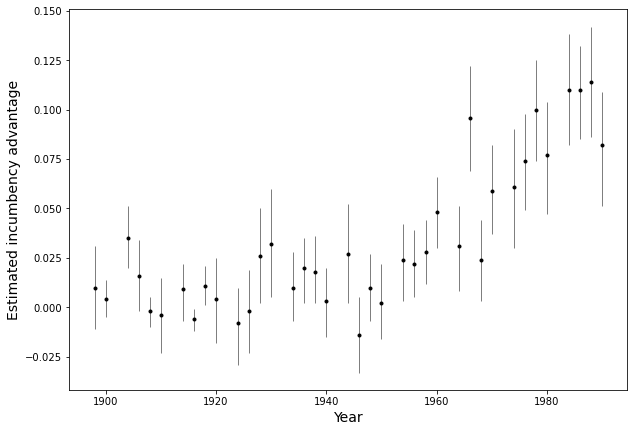

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(years, means, '.', color = 'black')
for i in range(len(years)):
    plt.vlines(x=years[i], ymin=lowers[i], ymax=uppers[i], color = 'black', lw=0.5)
plt.xlabel('Year', size=14)
plt.ylabel('Estimated incumbency advantage', size=14)
plt.show()